<a href="https://colab.research.google.com/github/wmok12/Thesis-research-minimumwage-employment/blob/main/Model_coding_school_industry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading packages and data

In [ ]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score, make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV, ParameterGrid
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier

import matplotlib.pyplot as plt

import seaborn as sns

In [ ]:
# Loading data
dataset = pd.read_csv('/content/drive/MyDrive/Thesis/Voorbereiding/dataset_cps_Elementary and secondary schools.csv')

# Data pre-processing

In [ ]:
# Binary values
dataset['LABFORCE_binary'] = dataset['LABFORCE'].map({'In labor force': 1, 'Not labor force': 0})
dataset['SEX_binary'] = dataset['SEX'].map({'Male': 1, 'Female': 0})
dataset['CLASSWKR_binary'] = dataset['CLASSWKR'].map({'Self-employed': 1, 'Work for wages': 0})
dataset['EMPSTAT_binary'] = dataset['EMPSTAT'].map({'Unemployed': 1, 'Employed': 0})

# Split the dataset in X and y
X = dataset[['AGE', 'SEX_binary', 'MINIMUM WAGE', 'EDUC', 'CLASSWKR_binary', 'MARST', 'RACE', 'LABFORCE_binary']]
y = dataset['EMPSTAT_binary']

# Preprocessing
numerical_features = ['AGE','MINIMUM WAGE']
numerical_transformer = StandardScaler()

binary_features = ['SEX_binary', 'CLASSWKR_binary', 'LABFORCE_binary']

categorical_features_encode = ['MARST', 'RACE']
categorical_transformer_encode = OneHotEncoder(handle_unknown='ignore')

education_order = [['No schooling', 'Grades 1 t/m 4', 'Grades 5 or 6', 'Grades 7 or 8', 'Grade 9', 'Grade 10', 'Grade 11', 'Grade 12', 'High school diploma','Some college',  'AC degree, occupational program', 'AC degree, academic program', 'Bachelor\'s degree', 'Master/s degree', 'Professional school degree', 'Doctorate degree']]
categorical_features_label = ['EDUC']
categorical_transformer_label = OrdinalEncoder(categories = education_order)

preprocessor = ColumnTransformer(transformers=[
    ('cat_encode', categorical_transformer_encode, categorical_features_encode),
    ('cat_label', categorical_transformer_label, categorical_features_label),
    ('binary', 'passthrough', binary_features),
    ('num', numerical_transformer, numerical_features)
])

X = preprocessor.fit_transform(X)

# Get the feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Convert the transformed data back to DataFrames with proper feature names
X = pd.DataFrame(X, columns=feature_names)

# Split data into 80% training/validation data and 20% testing data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Split data the training/validation data into 60% training data and 20% into validation data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42)


# Logistic Regression (baseline) - addressing class imbalance

In [ ]:
# RFE selector based on EDA
rfe_lr = RFE(estimator=LogisticRegression(max_iter=10000, random_state=42), n_features_to_select=2)

# Logistic regression pipeline
lr_model = ImbPipeline(steps=[
    ('feature_selection', rfe_lr),
    ('classifier', LogisticRegression(max_iter=10000, random_state=42))
])

# Setting parameters
lr_param_grid = {
    'classifier__solver': ['lbfgs', 'saga'],
    'classifier__penalty': ['l2', 'elasticnet'],
    'classifier__C': [0.1, 1],
    'classifier__class_weight': [
        {0: 1, 1: 2},
        {0: 1, 1: 3}
    ],
    'classifier__l1_ratio': [0.5]
}

# Filtering invalid parameter combinations
valid_params = []
for params in ParameterGrid(lr_param_grid):
    if params['classifier__penalty'] == 'elasticnet' and params['classifier__solver'] != 'saga':
        continue
    if params['classifier__penalty'] != 'elasticnet' and 'classifier__l1_ratio' in params:
        continue
    valid_params.append(params)

# K-Fold Cross-Validation
kf_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Scoring with weighted F1-score
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1_weighted': make_scorer(f1_score, average='weighted')
}

# GridSearchCV
lr_grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=lr_param_grid,
    cv=kf_cv,
    scoring=scoring,
    refit='f1_weighted',  # Optimalisatie voor weighted F1-score
    n_jobs=-1,
    verbose=3
)

# Train the model on the training data using GridSearchCV
lr_grid_search.fit(X_train, y_train)

#-------------------------------------------------------------------------------
# Resultats per fold
cv_results = pd.DataFrame(lr_grid_search.cv_results_)

# Columns for per-fold scores
fold_columns = [col for col in cv_results.columns if "split" in col and "test_f1_weighted" in col]

# Best hyperparameters and scores per fold
best_params_per_fold = {}
for i, fold_col in enumerate(fold_columns):
    best_index = cv_results[fold_col].idxmax()
    best_params_per_fold[f"fold{i+1}"] = {
        "best_params": {param: cv_results.loc[best_index, param] for param in cv_results.columns if param.startswith("param_")},
        "best_score": cv_results.loc[best_index, fold_col]
    }

# Display the best hyperparameters and scores per fold
print("Beste hyperparameters en scores per fold:")
for fold, result in best_params_per_fold.items():
    print(f"{fold}:")
    print(f"  Best Hyperparameters: {result['best_params']}")
    print(f"  Best Score: {result['best_score']:.4f}")

# Show the best final hyperparameters and score
print("Best hyperparameters:", lr_grid_search.best_params_)
print("Best accuracy:", lr_grid_search.best_score_)
print("Best precision:", lr_grid_search.cv_results_['mean_test_precision'][lr_grid_search.best_index_])
print("Best recall:", lr_grid_search.cv_results_['mean_test_recall'][lr_grid_search.best_index_])
print("Best F1-score:", lr_grid_search.cv_results_['mean_test_f1_weighted'][lr_grid_search.best_index_])

#-------------------------------------------------------------------------------
# Training data
# Make prediction on training data
lr_y_pred_train = lr_grid_search.best_estimator_.predict(X_train)

# Classification report for validation data
print("Classification report for Training data - LR")
print(classification_report(y_train, lr_y_pred_train))

# Validation data
# Make prediction on validation data
lr_y_pred_val = lr_grid_search.best_estimator_.predict(X_val)

# Classification report for validation data
print("Classification report for validation data - LR")
print(classification_report(y_val, lr_y_pred_val))

# Testing data
# Make prediction on testing data
lr_y_pred_test = lr_grid_search.best_estimator_.predict(X_test)

# Classification report for testing data
print("Classification report for testing data - LR")
print(classification_report(y_test, lr_y_pred_test))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 333, in fit
    self._final_estimator.fit(Xt, yt, **last_step_params["fit"])
  File "/usr/local/lib/py

Beste hyperparameters en scores per fold:
fold1:
  Best Hyperparameters: {'param_classifier__C': 0.1, 'param_classifier__class_weight': {0: 1, 1: 2}, 'param_classifier__l1_ratio': 0.5, 'param_classifier__penalty': 'l2', 'param_classifier__solver': 'lbfgs'}
  Best Score: 0.9579
fold2:
  Best Hyperparameters: {'param_classifier__C': 0.1, 'param_classifier__class_weight': {0: 1, 1: 2}, 'param_classifier__l1_ratio': 0.5, 'param_classifier__penalty': 'l2', 'param_classifier__solver': 'lbfgs'}
  Best Score: 0.9545
fold3:
  Best Hyperparameters: {'param_classifier__C': 0.1, 'param_classifier__class_weight': {0: 1, 1: 2}, 'param_classifier__l1_ratio': 0.5, 'param_classifier__penalty': 'l2', 'param_classifier__solver': 'lbfgs'}
  Best Score: 0.9597
fold4:
  Best Hyperparameters: {'param_classifier__C': 0.1, 'param_classifier__class_weight': {0: 1, 1: 2}, 'param_classifier__l1_ratio': 0.5, 'param_classifier__penalty': 'l2', 'param_classifier__solver': 'lbfgs'}
  Best Score: 0.9541
fold5:
  Best 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


# Random Forest - no hyperparameter tuning

In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Random Forest
rf_model = ImbPipeline(steps=[
    ('classifier', RandomForestClassifier(random_state = 42))
])

# Train random_search on the training data
rf_model.fit(X_train, y_train)

# Validation data
# Make prediction on validation data
rf_y_pred_val = rf_model.predict(X_val)

# Print classification report
print("Classification report for validation data - RF")
print(classification_report(y_val, rf_y_pred_val))

# Testing data
# Make prediction on testing data
rf_y_pred_test = rf_model.predict(X_test)

# Print classification report
print("Classification report for testing data - RF")
print(classification_report(y_test, rf_y_pred_test))

Classification report for validation data - RF
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3162
           1       0.73      0.44      0.55       149

    accuracy                           0.97      3311
   macro avg       0.85      0.72      0.77      3311
weighted avg       0.96      0.97      0.96      3311

Classification report for testing data - RF
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3959
           1       0.71      0.47      0.57       180

    accuracy                           0.97      4139
   macro avg       0.84      0.73      0.78      4139
weighted avg       0.96      0.97      0.97      4139



# Random Forest - addressing imbalance

In [ ]:
# RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42)

# Use RFE to select the top 2 features
rfe = RFE(estimator=rf_model, n_features_to_select=9)

# Random Forest
rf_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state = 42)),
    ('feature_selection', rfe),
    ('classifier', rf_model)
])

# Train random_search on the training data
rf_pipeline.fit(X_train, y_train)

# Validation data
# Make prediction on validation data
rf_y_pred_val = rf_pipeline.predict(X_val)

# Print classification report
print("Classification report for validation data - RF")
print(classification_report(y_val, rf_y_pred_val))

# Testing data
# Make prediction on testing data
rf_y_pred_test = rf_pipeline.predict(X_test)

# Print classification report
print("Classification report for testing data - RF")
print(classification_report(y_test, rf_y_pred_test))

Classification report for validation data - RF
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3162
           1       0.49      0.49      0.49       149

    accuracy                           0.95      3311
   macro avg       0.73      0.73      0.73      3311
weighted avg       0.95      0.95      0.95      3311

Classification report for testing data - RF
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3959
           1       0.54      0.49      0.52       180

    accuracy                           0.96      4139
   macro avg       0.76      0.74      0.75      4139
weighted avg       0.96      0.96      0.96      4139



In [ ]:
# Take the RFE-stap out of the pipeline
rfe_step = rf_pipeline.named_steps['feature_selection']

selected_features_boolean = rfe_step.support_
selected_feature_names = pd.Series(feature_names)[selected_features_boolean].tolist()

# Display the selected features
print("Geselecteerde features door RFE:", selected_feature_names)


Geselecteerde features door RFE: ['cat_encode__MARST_Married', 'cat_encode__MARST_Others', 'cat_encode__RACE_BAME', 'cat_encode__RACE_White', 'cat_label__EDUC', 'binary__SEX_binary', 'binary__LABFORCE_binary', 'num__AGE', 'num__MINIMUM WAGE']


# Random Forest - hyperparameter tuning random and gridsearch

In [ ]:
# RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42)

# Use RFE
rfe = RFE(estimator=rf_model, n_features_to_select=9)

# Pipeline
rf_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state = 42)),
    ('feature_selection', rfe),
    ('classifier', rf_model)
])

# K-Fold Cross-Validation
kf_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label = 1),
    'recall': make_scorer(recall_score, pos_label = 1),
    'f1_weighted': make_scorer(f1_score, average = "weighted")
}

rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__class_weight': ['balanced',
     {0: 1, 1: 2},
     {0: 1, 1: 3}]
}


# GridSearchCV
rf_grid_search = GridSearchCV(
    estimator = rf_pipeline,
    param_grid = rf_param_grid,
    cv = kf_cv,               # Using K-Fold Cross-Validation as cv
    scoring = scoring,
    refit = 'f1_weighted',    # f1 needs to be trained again
    n_jobs = -1,              # -1 will use all available processors
    verbose = 1               # tijd besparen
)


# Train the model on the training data
rf_grid_search.fit(X_train, y_train)

#-------------------------------------------------------------------------------
# Results per fold
cv_results = pd.DataFrame(rf_grid_search.cv_results_)

# Columns for per-fold scores
fold_columns = [col for col in cv_results.columns if "split" in col and "test_f1" in col]

# For each fold finding the best parameters
best_params_per_fold = {}
for i, fold_col in enumerate(fold_columns):
    best_index = cv_results[fold_col].idxmax()
    best_params_per_fold[f"fold {i+1}"] = {
        "best_params": {param: cv_results.loc[best_index, param] for param in cv_results.columns if param.startswith("param_")},
        "best_score": cv_results.loc[best_index, fold_col]
    }

# Display the beste hyperparameters per fold
for fold, result in best_params_per_fold.items():
    print(f"{fold}:")
    print(f"  Best Hyperparameters: {result['best_params']}")
    print(f"  Best Weighted F1-Score: {result['best_score']:.4f}")

print("Best hyperparameters:", rf_grid_search.best_params_)
print("Best accuracy:", rf_grid_search.best_score_)
print("Best precision:", rf_grid_search.cv_results_['mean_test_precision'][rf_grid_search.best_index_])
print("Best recall:", rf_grid_search.cv_results_['mean_test_recall'][rf_grid_search.best_index_])
print("Best F1-score:", rf_grid_search.cv_results_['mean_test_f1_weighted'][rf_grid_search.best_index_])

#-------------------------------------------------------------------------------
# Training data
# Make prediction on validation data
rf_y_pred_train = rf_grid_search.predict(X_train)

# Print classification report
print("Classification report for training data - RF")
print(classification_report(y_train, rf_y_pred_train))

# Validation data
# Make prediction on validation data
rf_y_pred_val = rf_grid_search.predict(X_val)

# Print classification report
print("Classification report for validation data - RF")
print(classification_report(y_val, rf_y_pred_val))

# Testing data
# Make prediction on testing data
rf_y_pred_test = rf_grid_search.predict(X_test)

# Print classification report
print("Classification report for testing data - RF")
print(classification_report(y_test, rf_y_pred_test))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
fold 1:
  Best Hyperparameters: {'param_classifier__class_weight': 'balanced', 'param_classifier__max_depth': None, 'param_classifier__n_estimators': 200}
  Best Weighted F1-Score: 0.9586
fold 2:
  Best Hyperparameters: {'param_classifier__class_weight': 'balanced', 'param_classifier__max_depth': None, 'param_classifier__n_estimators': 100}
  Best Weighted F1-Score: 0.9576
fold 3:
  Best Hyperparameters: {'param_classifier__class_weight': 'balanced', 'param_classifier__max_depth': None, 'param_classifier__n_estimators': 100}
  Best Weighted F1-Score: 0.9609
fold 4:
  Best Hyperparameters: {'param_classifier__class_weight': 'balanced', 'param_classifier__max_depth': None, 'param_classifier__n_estimators': 200}
  Best Weighted F1-Score: 0.9560
fold 5:
  Best Hyperparameters: {'param_classifier__class_weight': {0: 1, 1: 2}, 'param_classifier__max_depth': None, 'param_classifier__n_estimators': 200}
  Best Weighted F1-Score: 0.95

# Feature importance - RF

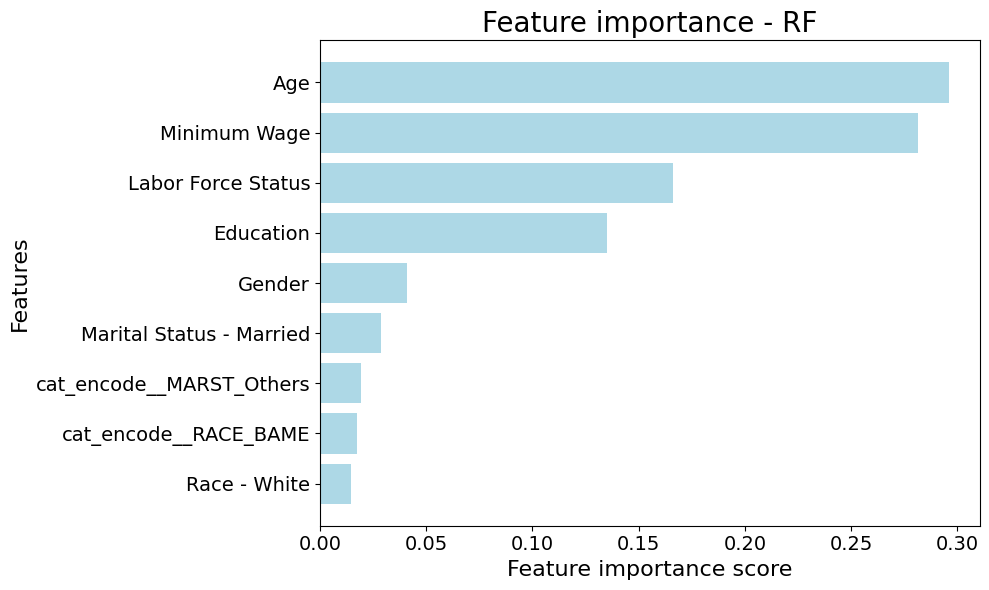

In [ ]:
# changing the features to more readable names
feature_name_mapping = {
    'num__AGE': 'Age',
    'num__MINIMUM WAGE': 'Minimum Wage',
    'cat_label__EDUC': 'Education',
    'binary__LABFORCE_binary': 'Labor Force Status',
    'binary__CLASSWKR_binary': 'Class of Worker',
    'binary__SEX_binary': 'Gender',
    'cat_encode__MARST_Married': 'Marital Status - Married',
    'cat_encode__RACE_White': 'Race - White',
    'cat_encode__MARST_Never married': 'Marital Status - Never Married'
}

# Extract selected features from the fitted RFE
fitted_rfe = rf_grid_search.best_estimator_.named_steps['feature_selection']
fitted_rf = rf_grid_search.best_estimator_.named_steps['classifier']

# Get the selected feature names using RFE
selected_features = X_train.columns[fitted_rfe.support_]

# Get feature importances from the fitted RandomForestClassifier
feature_importances = fitted_rf.feature_importances_

# Sort the features and their importance scores
sorted_idx = np.argsort(feature_importances)
sorted_features = selected_features[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Rename the features using the mapping dictionary
renamed_sorted_features = [feature_name_mapping.get(feat, feat) for feat in sorted_features]

# Create a horizontal bar chart for feature importances
plt.figure(figsize=(10, 6))
plt.barh(renamed_sorted_features, sorted_importances, color='#ADD8E6')
plt.xlabel('Feature importance score', fontsize = 16)
plt.ylabel('Features', fontsize = 16)
plt.title('Feature importance - RF', fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


# Confusion matrix displayed as heatmap

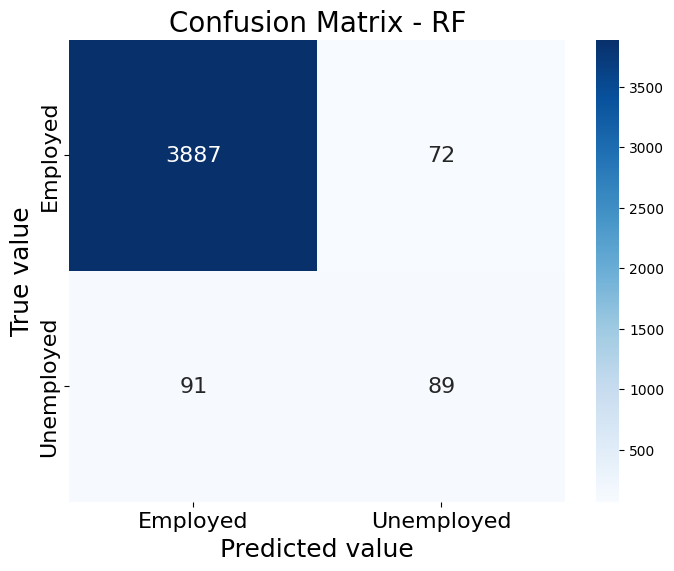

In [ ]:
# Confusion matrix for the test data
conf_matrix = confusion_matrix(y_test, rf_y_pred_test)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Employed', 'Unemployed'], yticklabels=['Employed', 'Unemployed'],annot_kws={"size": 16} )
plt.xlabel('Predicted value', fontsize=18)
plt.ylabel('True value', fontsize=18)
plt.title('Confusion Matrix - RF', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


# Actual vs predicted - scatterplot

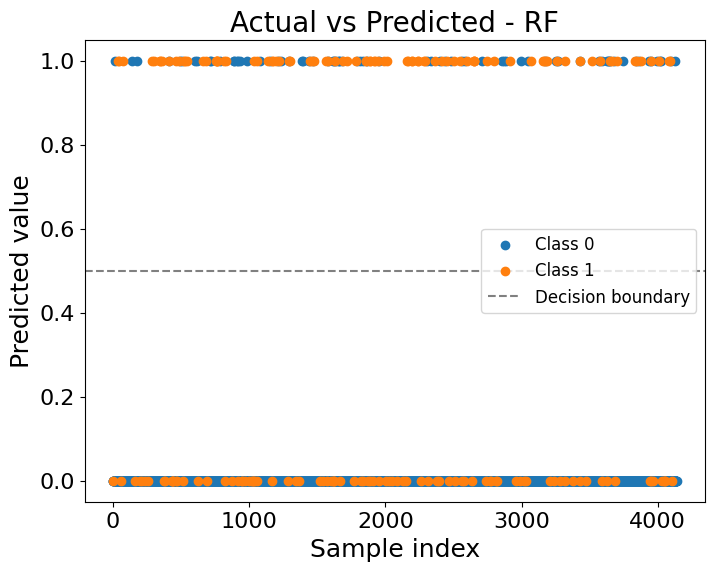

In [ ]:
# Actual en predicted values
actual = y_test
predicted = rf_y_pred_test

classes = np.unique(actual)

# Scatterplot
plt.figure(figsize=(8, 6))
for cls in classes:
    plt.scatter(
        np.where(actual == cls)[0],
        predicted[actual == cls],
        label=f"Class {cls}"
    )

plt.axhline(y=0.5, color="gray", linestyle="--", label="Decision boundary")
plt.xlabel("Sample index", fontsize=18)
plt.ylabel("Predicted value", fontsize=18)
plt.title("Actual vs Predicted - RF", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="best", fontsize = 12)
